# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 
num_features = 784 

learning_rate = 0.001 
training_steps = 3000 
batch_size = 256 
display_step = 100 

n_hidden_1 = 128 
n_hidden_2 = 256

In [3]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
x_train, x_test = x_train / 255., x_test / 255.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [4]:
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.layer1 = DenseLayer(num_features, n_hidden_1)
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)
    self.out = DenseLayer(n_hidden_2, num_classes)

  def __call__(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.out(x, activation=1)
    return x

In [5]:
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [6]:
neural_net = NN(name="mnist")

def train(neural_net, input_x, output_y):
  optimizer = tf.optimizers.SGD(learning_rate)

  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    trainable_variables = neural_net.trainable_variables
    gradients = g.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [7]:
loss_history = []  
accuracy_history = [] 

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 100, loss: 264.748657, accuracy: 0.691406
step: 200, loss: 310.142914, accuracy: 0.757812
step: 300, loss: 179.490768, accuracy: 0.820312
step: 400, loss: 159.479736, accuracy: 0.808594
step: 500, loss: 118.618423, accuracy: 0.847656
step: 600, loss: 131.464478, accuracy: 0.859375
step: 700, loss: 120.690605, accuracy: 0.867188
step: 800, loss: 102.621338, accuracy: 0.878906
step: 900, loss: 103.070602, accuracy: 0.871094
step: 1000, loss: 69.684921, accuracy: 0.917969
step: 1100, loss: 102.510010, accuracy: 0.875000
step: 1200, loss: 77.236641, accuracy: 0.898438
step: 1300, loss: 108.464211, accuracy: 0.855469
step: 1400, loss: 92.484497, accuracy: 0.902344
step: 1500, loss: 94.560410, accuracy: 0.894531
step: 1600, loss: 60.287357, accuracy: 0.914062
step: 1700, loss: 67.898819, accuracy: 0.906250
step: 1800, loss: 80.890320, accuracy: 0.906250
step: 1900, loss: 111.101158, accuracy: 0.886719
step: 2000, loss: 56.276756, accuracy: 0.914062
step: 2100, loss: 62.677933, accuracy

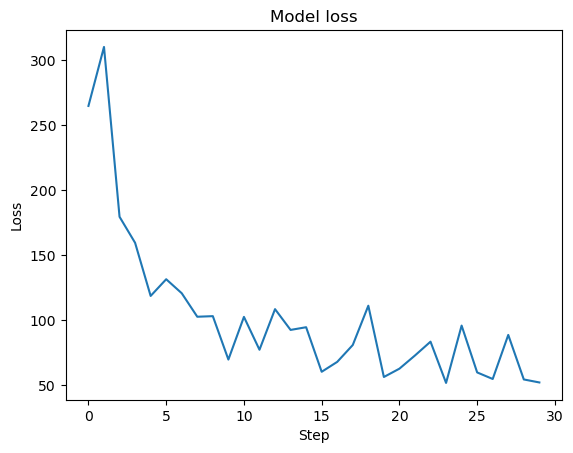

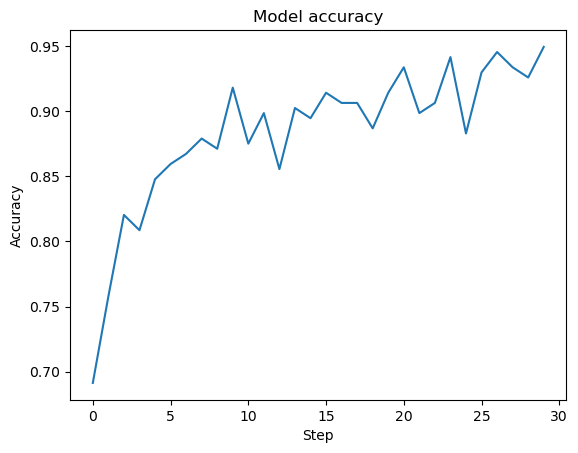

Test Accuracy: 0.903600


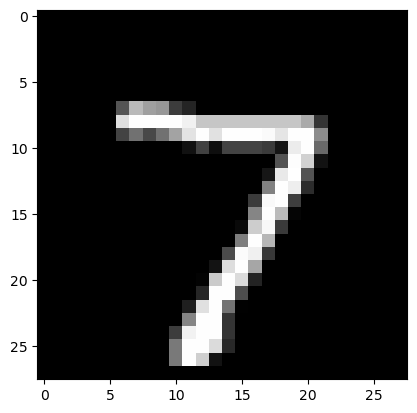

Model prediction: 7


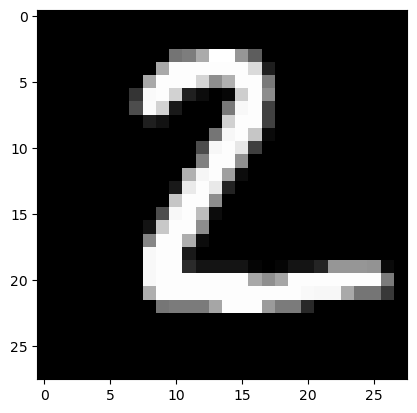

Model prediction: 2


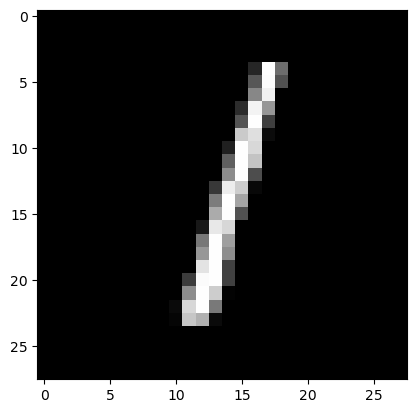

Model prediction: 1


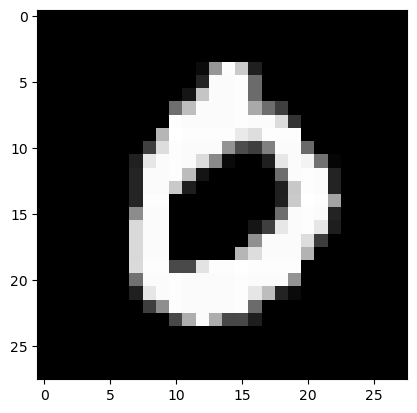

Model prediction: 0


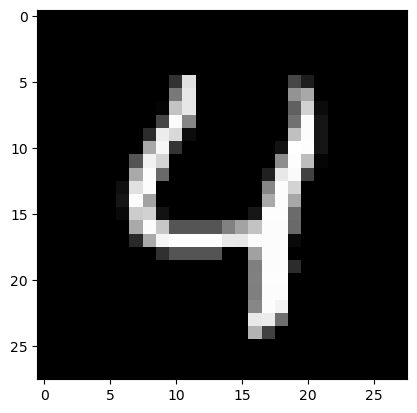

Model prediction: 4


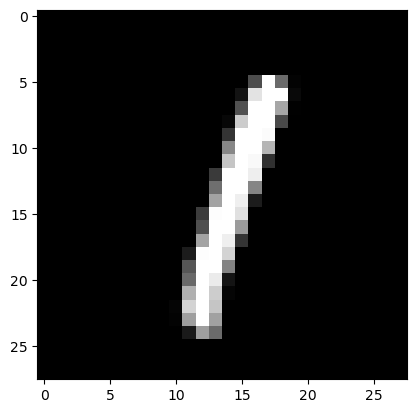

Model prediction: 1


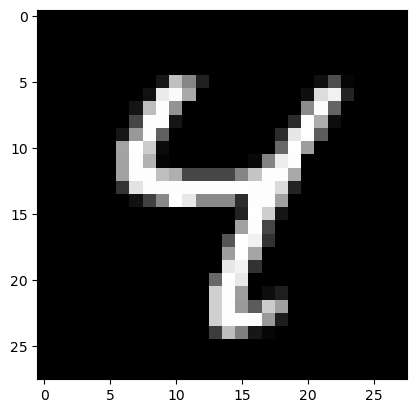

Model prediction: 4


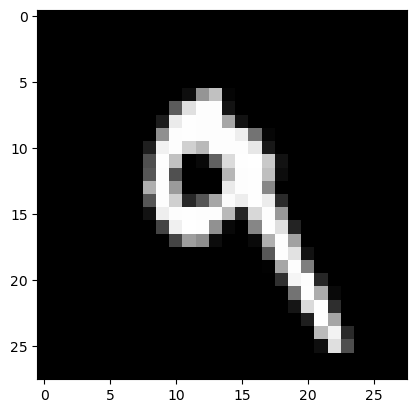

Model prediction: 9


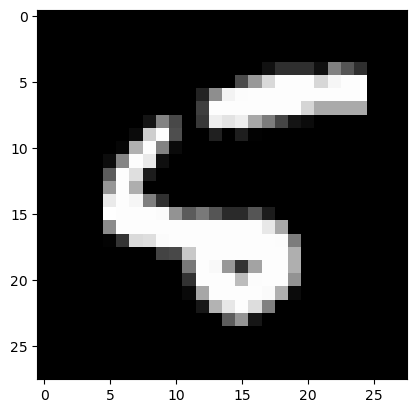

Model prediction: 2


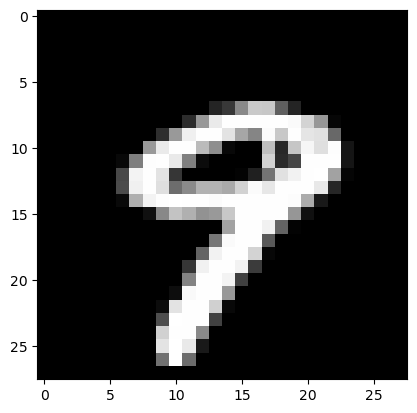

Model prediction: 9


In [8]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Step')
plt.show()

plt.plot(accuracy_history)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Step')
plt.show()

pred = neural_net(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

n_images = 10
test_images = x_test[:n_images]
predictions = neural_net(test_images)

for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction: %i" % np.argmax(predictions.numpy()[i]))

In [10]:
from sklearn.metrics import classification_report
y_pred = neural_net(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       980
           1       0.97      0.97      0.97      1135
           2       0.89      0.89      0.89      1032
           3       0.90      0.87      0.88      1010
           4       0.90      0.90      0.90       982
           5       0.89      0.85      0.87       892
           6       0.92      0.93      0.92       958
           7       0.90      0.92      0.91      1028
           8       0.84      0.88      0.86       974
           9       0.89      0.86      0.87      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

